#### Explanation 

-  We are importing tensorflow (we are using space_to_depth and so tf is required).

In [0]:
# https://keras.io/
!pip install -q keras
import keras

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k


# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model
from keras.layers.merge import concatenate

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
img_channels

3

In [0]:
img_rows

32

In [0]:
img_cols

32

#### EXPLANATION

-  We are looping through class by class and taking the index of one specific class in loop.
-  Taking all those indexes training features and as features_idx.
-  Picking random number and displaying that image and setting title.

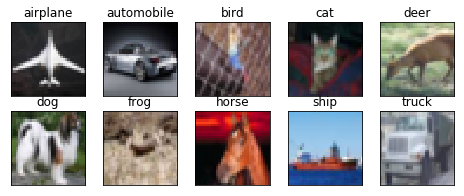

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#### EXPLANATION

-  It predicts test results and take the maximum index value and so it means model predicted that index category.
-  Equate the results, sum it, divide and print the accuracy.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### EXPLANATION
-  It usually reduce the resolution by half and increases the channels by four times, used while concatenate.

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
input = Input(shape=(img_rows,img_cols,img_channels,))

### ===========================Normal Convolution=============================================

#Layer 1
layer1 = Conv2D(32,(3,3),strides=(1,1),name='conv_1',border_mode='same',use_bias=False)(input)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)
layer1 = Dropout(0.1)(layer1)

### ========================================================================

### ===========================SPATIALLY SEPARABLE / SEPARABLE ---> 3X1 THEN 1X3===============
#Layer 2
layer2 = BatchNormalization(name='norm_2')(layer1)
layer2 = Conv2D(64, (3,1), strides=(1,1),name='conv_2',border_mode='same', use_bias=False)(layer2)
layer2 = Activation('relu')(layer2)
layer2 = Dropout(0.1)(layer2)

# Layer 3
layer3 = BatchNormalization(name='norm_3')(layer2)
layer3 = Conv2D(128, (1,3), strides=(1,1),name='conv_3',border_mode='same', use_bias=False)(layer3)
layer3 = Activation('relu')(layer3)
layer3 = Dropout(0.1)(layer3)

### ========================================================================

### ===============================SAVING LAYER3 FOR CONCATENATING WITH FIRST GROUPED CONVOLUTION(3X3 AND 5X5)===
skip_connection1 = layer3
### ========================================================================

############################TRANSITION BLOCK#############################

bottleneck1 = Conv2D(10,(1,1),strides=(1,1),name='bottleneck1',border_mode='same',use_bias=False)(layer3)
Maxpool1 = MaxPooling2D(pool_size=(2, 2))(bottleneck1)

#########################################################

### ===========================DEPTHWISE Convolution=============================================

# Layer 4
layer4 = BatchNormalization(name='norm_4')(Maxpool1)
layer4 = SeparableConv2D(32, (3,3), strides=(1,1),name='conv_4',border_mode='same', use_bias=False)(layer4)
layer4 = Activation('relu')(layer4)
layer4 = Dropout(0.1)(layer4)

### ========================================================================

### ===========================FIRST GROUP Convolution AND CONCATENATION USING SAVED LAYER3=============================================

# Layer 5
layer5 = BatchNormalization(name='norm_5')(layer4)
layer5 = Conv2D(64, (5,5), strides=(1,1),name='conv_5',border_mode='same', use_bias=False)(layer5)
layer5 = Activation('relu')(layer5)
layer5 = Dropout(0.1)(layer5)

skip_connection_result1 = Conv2D(32, (1,1), strides=(1,1), padding='same', name='conv_skip1', use_bias=False)(skip_connection1)
skip_connection_result1 = BatchNormalization(name='norm_6')(skip_connection_result1)
skip_connection_result1 = Activation('relu')(skip_connection_result1)
skip_connection_result1 = Lambda(space_to_depth_x2)(skip_connection_result1)

layer6 = concatenate([skip_connection_result1, layer5])

skip_connection2 = layer6 ####### --------------> SAVING LAYER6 FOR CONCATENATING WITH SECOND GROUP CONVOLUTION (3X3 AND DILATED 5X5)

### ========================================================================

############################TRANSITION BLOCK#############################

#Maxpool
bottleneck2 = Conv2D(10,(1,1),strides=(1,1),name='bottleneck2',border_mode='same',use_bias=False)(layer6)
Maxpool2 = MaxPooling2D(pool_size=(2, 2))(bottleneck2)

#########################################################


### ===========================SECOND GROUP Convolution AND CONCATENATION USING SAVED LAYER6=============================================

# Layer 7
layer7 = BatchNormalization(name='norm_7')(Maxpool2)
layer7 = Conv2D(32, (3,3), strides=(1,1),name='conv_7',border_mode='same', use_bias=False, dilation_rate = 1)(layer7)
layer7 = Activation('relu')(layer7)

# Layer 8
layer8 = BatchNormalization(name='norm_8')(layer7)
layer8 = Conv2D(32, (3,3), strides=(1,1),name='conv_8',border_mode='same', use_bias=False,dilation_rate = 2)(layer8)
layer8 = Activation('relu')(layer8)

skip_connection_result2 = Conv2D(32, (1,1), strides=(1,1), padding='same', name='conv_9', use_bias=False)(skip_connection2)
skip_connection_result2 = BatchNormalization(name='norm_9')(skip_connection_result2)
skip_connection_result2 = Activation('relu')(skip_connection_result2)
skip_connection_result2 = Lambda(space_to_depth_x2)(skip_connection_result2)

### ========================================================================

layer9 = concatenate([skip_connection_result2, layer8])

layer10 = Conv2D(10,(8,8),strides=(1,1),name='conv_10',use_bias=False)(layer9)
layer11 = Flatten()(layer10)

output = Activation('softmax')(layer11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), name="conv_1", use_bias=False, padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), strides=(1, 1), name="conv_2", use_bias=False, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), strides=(1, 1), name="conv_3", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), strides=(1, 1), name="bottleneck1", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: 

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   864         input_16[0][0]                   
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 32, 32, 32)   0           norm_1[0][0]                     
__________________________________________________________________________________________________
dropout_28

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 54s 138ms/step - loss: 1.4323 - acc: 0.4991 - val_loss: 1.1467 - val_acc: 0.5940
Epoch 2/50
390/390 [==============================] - 44s 112ms/step - loss: 0.9582 - acc: 0.6631 - val_loss: 1.1253 - val_acc: 0.6205
Epoch 3/50
390/390 [==============================] - 43s 111ms/step - loss: 0.7904 - acc: 0.7225 - val_loss: 0.8727 - val_acc: 0.6995
Epoch 4/50
390/390 [==============================] - 43s 111ms/step - loss: 0.6766 - acc: 0.7633 - val_loss: 0.8292 - val_acc: 0.7162
Epoch 5/50
390/390 [==============================] - 43s 111ms/step - loss: 0.5912 - acc: 0.7936 - val_loss: 0.7706 - val_acc: 0.7338
Epoch 6/50
390/390 [==============================] - 43s 111ms/step - loss: 0.5194 - acc: 0.8187 - val_loss: 0.7932 - val_acc: 0.7380
Epoch 7/50
390/390 [==============================] - 43s 111ms/step - loss: 0.4643 - acc: 0.8370 - val_loss: 0.7941 - val_acc: 0.7383
Epoch 8/50
390/390 [==============================] - 4

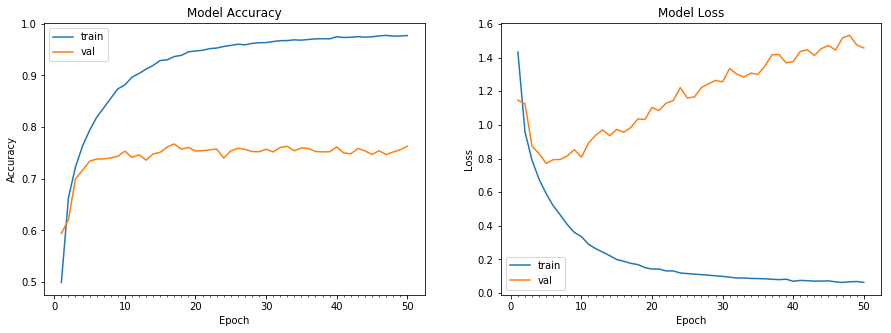

Accuracy on test data is: 76.28


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))